## ECE495 In-class Exercise 2: Spiking Neural Networks using NengoDL

This ICE uses NengoDL and TensorFlow's Keras to:

1. Load a prebuilt dataset.
2. Build a simple *spiking* neural network that classifies images.
3. Train the spiking neural network.
4. Evaluate the accuracy of the spiking network.

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
  
If you are using your virtual environment, the next section should run without issue. If you are not in your virtual environment (or your environment did not install properly), you'll see a lot of red.
  
Import Nengo, NengoDL, TensorFlow and other supporting libraries into your program to get started:

In [2]:
from urllib.request import urlretrieve

import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import nengo_dl

## Load a dataset

Load and prepare the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database). The pixel values of the images range from 0 through 255. Recall in ICE1, we had to normalize the values. For this spiking neural network, we do not have to do that. _Ensure you understand why we don't have to normalize the input values._

Add info about input nodes only being able to accept a vector and how the data is encoded to be sent into the network. [deets here](https://forum.nengo.ai/t/how-are-spikes-generated-within-nengodl/2130). Then have students pre-process the data so it's already flat going in.





<style>
    .questioncolor {
        background-color: #906752;
    }
</style>

<div class="questioncolor">

This is the first section you are required to edit!
1. Grab the dataset from tf.keras. [Look here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) to see the different datasets that TensorFlow Keras has at the ready and find commands to load the dataset. Replace `???` with the correct command on the first line. If you look further in TensorFlow documentation, you may see that there are other ways to call the MNIST dataset. It will be easiest within this notebook to use the command that begins with `tf.keras`.
2. Normalize the pixel values of the entire dataset. Replace the appropriate `???` to do so.

</div>

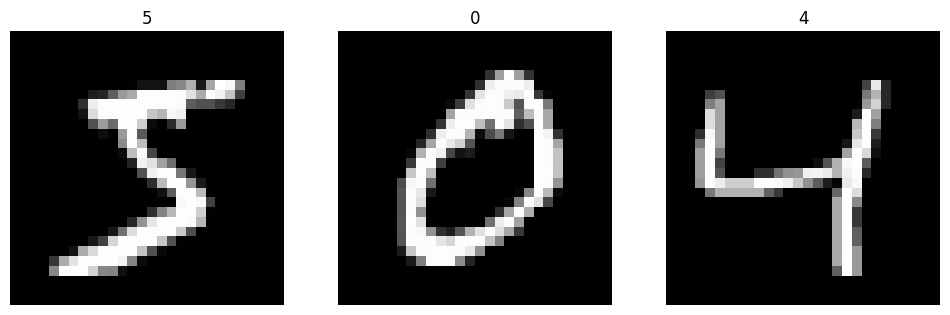

In [7]:
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# flatten images - note that they do not use a layer that flattens
#   the data and instead pre-process the data to flatten 
#   The layer cannot handle a 4 dimensional input = image#, timestep, xdim, ydim
#   Flatten to make it 3-D: image#, timestep, xdim*ydim
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(np.reshape(train_images[i], (28, 28)), cmap="gray")
    plt.axis("off")
    plt.title(str(train_labels[i]))

Almost all deep learning methods are based on gradient descent, which means that the network being optimized needs to be differentiable. Deep neural networks are usually built using rectified linear or sigmoid neurons, as these are differentiable nonlinearities. However, in neurmorphic modelling we often want to use spiking neurons, which are not differentiable. So the challenge is how to apply deep learning methods to spiking neural networks.

A method for accomplishing this is presented in Hunsberger and Eliasmith (2016). The basic idea is to use a differentiable approximation of the spiking neurons during the training process, and the actual spiking neurons during inference. NengoDL will perform these transformations automatically if the user tries to optimize a model containing a spiking neuron model that has an equivalent, differentiable rate-based implementation. In this example we will use these techniques to develop a network to classify handwritten digits (MNIST) in a spiking convolutional network.

We will use [TensorNodes](https://www.nengo.ai/nengo-dl/tensor-node.html) to construct the same network we constructed in ICE1 within Nengo. TensorNodes allow us to directly insert TensorFlow code into Nengo - making the parallels with standard deep networks very clear (i.e. the code looks the same!). 


In [8]:
with nengo.Network(seed=0) as net:
    # set some default parameters for the neurons that will make
    # the training progress more smoothly
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    neuron_type = nengo.LIF(amplitude=0.01)

    # this is an optimization to improve the training speed,
    # since we won't require stateful behaviour in this example
    nengo_dl.configure_settings(stateful=False)

    # the input node that will be used to feed in input images
    inp = nengo.Node(np.zeros(28 * 28))

    # add the Flatten layer
    x = nengo_dl.Layer(tf.keras.layers.Flatten(input_shape=(28, 28)))(inp)
    x = nengo_dl.Layer(neuron_type)(x)

    # add the first Dense layer
    x = nengo_dl.Layer(tf.keras.layers.Dense(128, activation="relu"))(x)
    x = nengo_dl.Layer(neuron_type)(x)

    # add the Dropout layer
    x = nengo_dl.Layer(tf.keras.layers.Dropout(0.2))(x)
    x = nengo_dl.Layer(neuron_type)(x)

    # Final dense layer: readout
    out = nengo_dl.Layer(tf.keras.layers.Dense(units=10))(x)

    # we'll create two different output probes, one with a filter
    # (for when we're simulating the network over time and
    # accumulating spikes), and one without (for when we're
    # training the network using a rate-based approximation)
    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=0.1, label="out_p_filt")

Construct a Simulator for the network

In [9]:
minibatch_size = 256
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size)

|                     Building network (0%)                    | ETA:  --:--:--
Build finished in 0:00:00
|#                         Optimizing graph                           | 0:00:00
|#             Optimizing graph: operator simplificaton               | 0:00:00
Optimizing graph: operator simplificaton finished in 0:00:00
|#                Optimizing graph: merging operators                 | 0:00:00
Optimizing graph: merging operators finished in 0:00:00
|#                Optimizing graph: ordering signals                  | 0:00:00
Optimizing graph: ordering signals finished in 0:00:00
|#                Optimizing graph: creating signals                  | 0:00:00
Optimizing graph: creating signals finished in 0:00:00
Optimization finished in 0:00:00
|#                        Constructing graph                          | 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00


c:\Users\Kaitlin.Fair\AppData\Local\anaconda3\envs\py3.10-nengo3.2\lib\site-packages\nengo_dl\simulator.py:456: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|###           Constructing graph: build stage (5%)              | ETA: 0:00:00
|##############Constructing graph: build stage (68%)             | ETA: 0:00:00
|  #                      Constructing graph                          | 0:00:00
Constructing graph: build stage finished in 0:00:00
Construction finished in 0:00:00


Next we set up our training/testing data. We need to incorporate time into this data, since Nengo models (and spiking neural networks in general) always contain a temporal aspect (think about the neurons in our brain! We don't feed our brain a photo and turn everything else off until we know what we are looking at. Our neurons are constantly taking in data and firing according to their receptive fields).

When training the model we’ll be using a rate-based approximation, so we can run that for a single timestep. But when testing the model we’ll be using the spiking neuron models, so we need to run the model for multiple timesteps in order to collect the spike data over time.



In [10]:
# add single timestep to training data
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

# when testing our network with spiking neurons we will need to run it
# over time, so we repeat the input/target data for a number of
# timesteps.
n_steps = 40
test_images = np.tile(test_images[:, None, :], (1, n_steps, 1))
test_labels = np.tile(test_labels[:, None, None], (1, n_steps, 1))

In order to quantify the network’s performance we’ll use a classification accuracy function (the percentage of test images classified correctly). We’re using a custom function here, because we only want to evaluate the output from the network on the final timestep (as we are simulating the network over time).

You may recall that we used Sparse Categorical Crossentropy as our loss function for our Tensorflow network. This is related to the Sparse Categorical Accuracy metric. This is a metric used to evaluate the accuracy of a classification model. Specifically, it computes the accuracy of the predicted labels against the true labels. In the case of sparse categorical accuracy, it is designed for scenarios where the true labels are integers (sparse) and the predictions are probabilities.

In [11]:
def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(y_true[:, -1], y_pred[:, -1])


# note that we use `out_p_filt` when testing (to reduce the spike noise)
sim.compile(loss={out_p_filt: classification_accuracy})

# print(
#    "Accuracy before training:",
#    sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"],
# )

Train the network! For training we’ll use the standard categorical cross entropy loss function, and the Adam optimizer.

This will take about 45 seconds to run. You can mess with the number of epochs, the minibatch size, or the number of time steps to speed things up. *If you do, note what changes in your results.*

In [12]:
# run training
sim.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss={out_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True)},
)
sim.fit(train_images, {out_p: train_labels}, epochs=5)

Epoch 1/5
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--


c:\Users\Kaitlin.Fair\AppData\Local\anaconda3\envs\py3.10-nengo3.2\lib\site-packages\nengo_dl\simulator.py:1892: UserWarning: Number of elements in input data (60000) is not evenly divisible by Simulator.minibatch_size (256); input data will be truncated.
  warnings.warn(


|##########    Constructing graph: build stage (15%)             | ETA: 0:00:00
|##############Constructing graph: build stage (47%)             | ETA: 0:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|##############Constructing graph: build stage (26%)             | ETA: 0:00:00
|##############Constructing graph: build stage (63%)             | ETA: 0:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00
234/234 [==============================]

Check the classification accuracy again.

This will take about 30-45 seconds to run (not sure why - bonus points if you figure it out). You can check the accuracy for a fraction of the results to speed things up (recall, there are 10,000 test images). *If you do, note the impact on your results.*


In [ ]:
sim.compile(loss={out_p_filt: classification_accuracy})
print(
    "Accuracy after training:",
    sim.evaluate(
        test_images[0 : 256 * 3], {out_p_filt: test_labels[0 : 256 * 3]}, verbose=0
    )["loss"],
    # sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"],
)

We can see that the spiking neural network is achieving ~95% accuracy, which is what we would expect for MNIST. n_steps could be increased to further improve performance, since we would get a more accurate measure of each spiking neuron’s output.



In [ ]:
data = sim.predict(test_images[:minibatch_size])

for i in range(5):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i, 0].reshape((28, 28)), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.plot(tf.nn.softmax(data[out_p_filt][i]))
    plt.legend([str(i) for i in range(10)], loc="upper left")
    plt.xlabel("timesteps")
    plt.ylabel("probability")
    plt.tight_layout()